In [ ]:
import pandas as pd
import numpy as np
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
print('All good!')

All good!


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Sorrentum/Nomics-Orders-gdax-BTC-USD-2023-03-03T00_21_01.127Z.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df

,bidPrice,bidAmount,askPrice,askAmount
0,23438.88,0.049863,23438.89,0.051502
1,23438.88,0.020000,23438.89,0.040000
2,23438.88,0.021332,23439.48,0.055464
3,23438.88,0.031998,23439.49,0.085326
4,23438.43,0.049028,23439.53,0.032002
...,...,...,...,...
73474,0.01,2600.000000,NaN,NaN
73475,0.01,2600.000000,NaN,NaN
73476,0.01,2600.000000,NaN,NaN
73477,0.01,1700.000000,NaN,NaN


In [ ]:
df.isna().sum()

In [ ]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'index'})

In [ ]:
model_data = df[['index','bidPrice']]

In [ ]:
del model_data['index']
scaler = MinMaxScaler(feature_range=(0,1))
bid_df = scaler.fit_transform(np.array(model_data).reshape(-1,1))

In [ ]:
training_size = int(len(bid_df)*0.9)
test_size = len(bid_df)-training_size
train_data,test_data = bid_df[0:training_size,:],bid_df[training_size:len(bid_df),:1]
print('train_data: ', train_data.shape)
print('test_data: ', test_data.shape)

train_data:  (66131, 1)
test_data:  (7348, 1)


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 10 
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (66120, 10, 1)
X_test:  (7337, 10, 1)


In [ ]:
model = Sequential() 
# Adding a LSTM layer with 10 internal units
model.add(LSTM(10,input_shape=(None,1),activation='relu'))
# Adding a Dense layer with 1 units.
model.add(Dense(1))
# Loss function + optimizer
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=10,verbose=1)

Epoch 1/10
6612/6612 [==============================] - 83s 13ms/step - loss: 1.1230e-06 - val_loss: 3.0860e-09
Epoch 2/10
6612/6612 [==============================] - 43s 6ms/step - loss: 1.0791e-06 - val_loss: 3.4644e-09
Epoch 3/10
6612/6612 [==============================] - 44s 7ms/step - loss: 9.3663e-07 - val_loss: 7.1368e-10
Epoch 4/10
6612/6612 [==============================] - 43s 7ms/step - loss: 7.6136e-07 - val_loss: 1.8200e-06
Epoch 5/10
6612/6612 [==============================] - 40s 6ms/step - loss: 8.3517e-07 - val_loss: 8.9676e-11
Epoch 6/10
6612/6612 [==============================] - 42s 6ms/step - loss: 7.4488e-07 - val_loss: 2.3674e-06
Epoch 7/10
6612/6612 [==============================] - 47s 7ms/step - loss: 7.8675e-07 - val_loss: 2.2400e-08
Epoch 8/10
6612/6612 [==============================] - 42s 6ms/step - loss: 1.1223e-06 - val_loss: 1.3222e-07
Epoch 9/10
6612/6612 [==============================] - 49s 7ms/step - loss: 5.5501e-07 - val_loss: 5.9679e-09


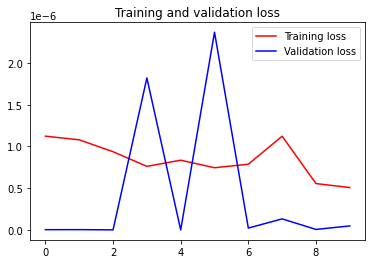

<Figure size 432x288 with 0 Axes>

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
look_back=time_step
trainPredictPlot = np.empty_like(bid_df)  
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(bid_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(bid_df)-1, :] = test_predict
names = cycle(['Original bid price','Train predicted bid price','Test predicted bid price'])
plotdf = pd.DataFrame({'index': df['index'],
                       'original_bid': df['bidPrice'],
                      'train_predicted_bid': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_bid': testPredictPlot.reshape(1,-1)[0].tolist()})
fig = px.line(plotdf,x=plotdf['index'], y=[plotdf['original_bid'],plotdf['train_predicted_bid'],
                                          plotdf['test_predicted_bid']],
              labels={'value':'bid price','date': 'Date'})
fig.update_layout(title_text='Comparision between original vs predicted bid price',
                  plot_bgcolor='white',legend_title_text='bid Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

230/230 [==============================] - 1s 4ms/step


In [27]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
from numpy import array
lst_output=[]
n_steps=time_step
i=0
pred_days = 60
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
temp_mat = np.empty(pred_days+1)
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]
next_predicted_days_value = temp_mat
next_predicted_days_value = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({
    'Predicted bid':next_predicted_days_value
})
names = cycle(['Predicted next 60  bid price'])
fig = px.line(new_pred_plot,x=new_pred_plot.index, y= new_pred_plot['Predicted bid'],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Next 60  bid price prediction',
                  plot_bgcolor='white',legend_title_text='bid Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [28]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [29]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data RMSE:  7.994218906152023
Train data MSE:  63.90753591947844
Train data MAE:  6.42527967519626
-------------------------------------------------------------------------------------
Test data RMSE:  5.127055988162274
Test data MSE:  26.286703105750636
Test data MAE:  5.12705598815579
-------------------------------------------------------------------------------------
Train data R2 score: 0.9999991773033572
Test data R2 score: 0.0
